In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.io import loadmat
from numpy.linalg import lstsq
from scipy.stats import t

## Project Work 2

## First Part: Contrast Map

In [2]:
def create_design_matrix(labels):
    """
    Creates a design matrix from a labels DataFrame.

    Parameters:
        labels (pandas.DataFrame): A DataFrame containing 'Condition' and 'Run' columns.

    Returns:
        pandas.DataFrame: The design matrix with conditions as columns.
    """
    # Get unique conditions from labels
    unique_conditions = labels["Condition"].unique()

    # Initialize the design matrix
    design_matrix = pd.DataFrame(0, index=np.arange(len(labels)), columns=unique_conditions)

    # Fill the design matrix
    for condition in unique_conditions:
        design_matrix[condition] = (labels["Condition"] == condition).astype(int)

    # Drop the 'rest' condition
    if "rest" in design_matrix.columns:
        design_matrix = design_matrix.drop(columns=["rest"])
        #print("'rest' condition dropped from the design matrix.")

    return design_matrix

In [3]:
def add_run_intercepts(design_matrix, labels): 
    """
    Adds intercept columns for each run to the design matrix.

    Parameters:
        design_matrix (pd.DataFrame): Original design matrix (time points × conditions).
        labels (pd.DataFrame): DataFrame with 'Condition' and 'Run' columns.

    Returns:
        pd.DataFrame: Design matrix with added intercept columns.
    """
    design_matrix_with_intercepts = design_matrix.copy()
    unique_runs = labels["Run"].unique()

    # Add intercept columns
    for run in unique_runs:
        run_column_name = f"Run_{run}"
        design_matrix_with_intercepts[run_column_name] = (labels["Run"] == run).astype(int)

    return design_matrix_with_intercepts

In [4]:
def convolve_conditions(design_matrix, hrf_sampled):
    """
    Convolves only the condition columns of the design matrix with the HRF.

    Parameters:
        design_matrix (pd.DataFrame): Design matrix with conditions and intercepts.
        hrf_sampled (numpy.ndarray): The sampled HRF.

    Returns:
        pd.DataFrame: Design matrix with convolved conditions and unmodified intercepts.
    """
    # Identify condition columns (non-intercept)
    condition_columns = [col for col in design_matrix.columns if not col.startswith("Run")]
    intercept_columns = [col for col in design_matrix.columns if col.startswith("Run")]

    # Initialize the convolved matrix
    convolved_matrix = pd.DataFrame(index=design_matrix.index)

    # Convolve conditions
    for condition in condition_columns:
        convolved_signal = np.convolve(design_matrix[condition], hrf_sampled, mode="full")[:len(design_matrix)]
        convolved_matrix[condition] = convolved_signal

    # Add intercept columns without modification
    for intercept in intercept_columns:
        convolved_matrix[intercept] = design_matrix[intercept]

    return convolved_matrix

In [5]:
def fit_glm_and_generate_beta_maps(bold_data, X):
    """
    Fits a General Linear Model (GLM) voxel-by-voxel and generates beta coefficient maps.

    Parameters:
        bold_data (numpy.ndarray): The 4D BOLD fMRI data with shape (X, Y, Z, Time).
        X (pandas.DataFrame): The convolved design matrix.

    Returns:
        numpy.ndarray: Beta coefficient maps with shape (X, Y, Z, N_conditions).
    """
    # Reshape the fMRI data for voxel-wise analysis
    Y = bold_data.reshape(-1, bold_data.shape[-1]).T  # Shape: (Time, Voxels)
    #print(f"fMRI data reshaped to: {Y.shape}")

    # Ensure the design matrix is aligned with the fMRI data
    assert Y.shape[0] == X.shape[0], "Mismatch in time points!"

    # Solve the GLM
    X_pinv = np.linalg.pinv(X)  # Use pseudo-inverse for stability
    beta_matrix = X_pinv @ Y

    
    # Compute residuals (optional, for model evaluation)
    residuals = Y - (X @ beta_matrix)  # Shape: (Time, N_voxels)

    # Reshape beta coefficients back to brain space
    beta_maps = beta_matrix.T.reshape(bold_data.shape[:-1] + (X.shape[1],))  # Shape: (X, Y, Z, N_conditions)

    return residuals, beta_maps

In [6]:
# Load the NIfTI file
bold_path = "subj1/bold.nii.gz"
bold_img = nib.load(bold_path)

# Extract the data as a NumPy array
bold_data = bold_img.get_fdata()

# Load the labels into a pandas DataFrame
labels = pd.read_csv("subj1/labels.txt", sep=" ", header=0, names=["Condition", "Run"])

# Create the design matrix
design_matrix = create_design_matrix(labels)

# Modify the convolved matrix
design_matrix_with_intercepts  = add_run_intercepts(design_matrix, labels)

# Load the HRF file
hrf_path = "hrf.mat"  
hrf_data = loadmat(hrf_path)
hrf_sampled = hrf_data.get("hrf_sampled", None).flatten()  # Downsampled HRF

convolved_matrix = convolve_conditions(design_matrix_with_intercepts, hrf_sampled)

# load design matrix as "convolved_matrix"
X = convolved_matrix.values
df = X.shape[0] - np.linalg.matrix_rank(X)

# Fit the GLM and get results
residuals, beta_maps = fit_glm_and_generate_beta_maps(bold_data, X)

In [7]:
def compute_contrast_map(beta_maps, design_matrix, contrast_vector, df, residual_variance, mask=None, variance_threshold=1e-6):
    """
    Computes a contrast map and voxelwise t-values.

    Parameters
    ----------
    beta_maps : np.ndarray
        4D array of beta coefficients, shape (X, Y, Z, N_conditions).
    design_matrix : pd.DataFrame
        Design matrix, shape (time_points, N_conditions).
    contrast_vector : array-like
        Contrast vector, length N_conditions (e.g., [1, -1, 0, ...]).
    df : int
        Degrees of freedom (time_points - rank(X)).
    residual_variance : np.ndarray
        Voxelwise residual variance, shape (X, Y, Z) or (n_mask_voxels,).
    mask : np.ndarray, optional
        Boolean array, shape (X, Y, Z). Restricts computations if provided.
    variance_threshold : float, optional
        Minimum variance threshold to avoid division by zero.

    Returns
    -------
    t_map_full : np.ndarray
        3D array of t-values, shape (X, Y, Z).
    """
    X = design_matrix.values
    X_size, Y_size, Z_size, n_conditions = beta_maps.shape
    assert n_conditions == X.shape[1], "Mismatch between beta_maps and design_matrix."
    contrast_vector = np.array(contrast_vector)
    assert len(contrast_vector) == n_conditions, "Mismatch between contrast_vector and design_matrix."

    cov_contrast = contrast_vector.T @ np.linalg.pinv(X) @ np.linalg.pinv(X).T @ contrast_vector
    contrast_betas = np.sum(beta_maps * contrast_vector, axis=3)

    if mask is not None:
        mask_flat = mask.flatten()
        residual_variance = residual_variance[mask] if residual_variance.ndim == 3 else residual_variance
        residual_variance = np.maximum(residual_variance, variance_threshold)

        SE = np.sqrt(residual_variance * cov_contrast)
        t_values = contrast_betas[mask] / SE

        t_map_full = np.full((X_size, Y_size, Z_size), np.nan, dtype=np.float32)
        t_map_full[mask] = t_values
    else:
        residual_variance = np.maximum(residual_variance, variance_threshold)
        SE = np.sqrt(residual_variance * cov_contrast)
        t_map_full = (contrast_betas / SE).astype(np.float32)

    return t_map_full

In [8]:
# Define the list of conditions
conditions = ['scissors', 'face', 'cat', 'shoe', 'house', 'scrambledpix', 'bottle',
              'chair', 'Run_0', 'Run_1', 'Run_2', 'Run_3', 'Run_4', 'Run_5', 'Run_6',
              'Run_7', 'Run_8', 'Run_9', 'Run_10', 'Run_11']

In [9]:
# Define a contrast vector for "house > face"
conditions = list(convolved_matrix.columns)
contrast_vector = np.zeros(len(conditions))
contrast_vector[conditions.index('face')]  = -1
contrast_vector[conditions.index('house')] = 1

In [10]:
# Compute the voxelwise sum of squared residuals
voxelwise_ss = np.sum(residuals**2, axis=0)  # shape: (n_voxels,)

# Divide by df
voxelwise_var = voxelwise_ss / df  # shape: (n_voxels,)

# Reshape to 3D
X_size, Y_size, Z_size, _ = bold_data.shape
residual_variance_3d = voxelwise_var.reshape(X_size, Y_size, Z_size)

In [11]:
# Compute the voxelwise sum of squared residuals
voxelwise_ss = np.sum(residuals**2, axis=0)  # shape: (n_voxels,)

# Divide by df
voxelwise_var = voxelwise_ss / df  # shape: (n_voxels,)

# Reshape to 3D
X_size, Y_size, Z_size, _ = bold_data.shape
residual_variance_3d = voxelwise_var.reshape(X_size, Y_size, Z_size)

In [12]:
# Compute the contrast map
t_map_full = compute_contrast_map(
    beta_maps=beta_maps,
    design_matrix=convolved_matrix,
    contrast_vector=contrast_vector,
    df=df,
    residual_variance=residual_variance_3d,  # shape (X, Y, Z)
    mask=None,  # None or mask_bool
)

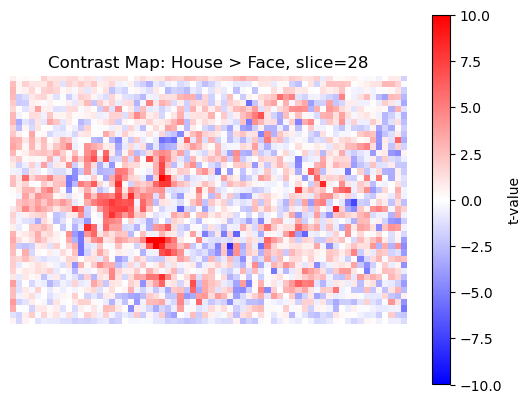

In [13]:
# Plot a slice
slice_idx = 28
plt.imshow(t_map_full[:, :, slice_idx], cmap="bwr", vmin=-10, vmax=10)
plt.colorbar(label="t-value")
plt.title("Contrast Map: House > Face, slice={}".format(slice_idx))
plt.axis("off")
plt.show()

C:\Users\flavi\miniconda3\Lib\site-packages\nilearn\plotting\img_plotting.py:1416: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  safe_get_data(stat_map_img, ensure_finite=True),


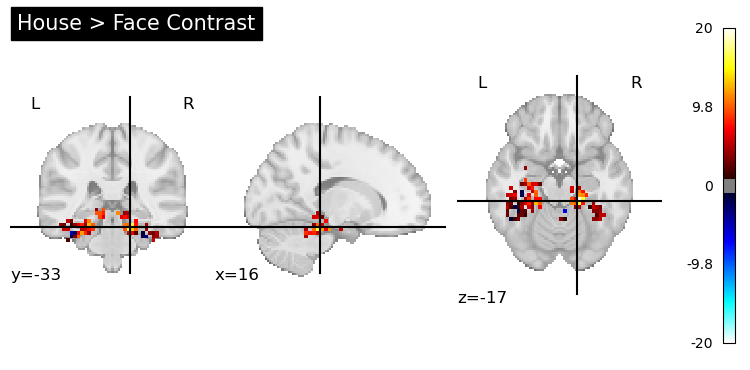

In [14]:
from nilearn.plotting import plot_stat_map
from nilearn.image import new_img_like

mask_path = "subj1/mask4_vt.nii.gz"
mask_data = nib.load(mask_path).get_fdata()  
mask_bool = (mask_data > 0)

t_map_masked = compute_contrast_map(beta_maps=beta_maps, design_matrix=convolved_matrix, contrast_vector=contrast_vector, df=df, 
    residual_variance=residual_variance_3d,
    mask=mask_bool
)

# Convert t_map to a NIfTI image
t_map_img = new_img_like(bold_img, t_map_masked)

# Plot the statistical map
plot_stat_map(t_map_img, title="House > Face Contrast", threshold=1.0)

In [15]:
# 1) Define a contrast vector for "scissors > cats"
conditions = list(convolved_matrix.columns)
contrast_vector = np.zeros(len(conditions))
contrast_vector[conditions.index('cat')]  = -1
contrast_vector[conditions.index('scissors')] = 1

In [18]:
# 2) Compute the contrast map (full volume) with no mask
t_map_masked = compute_contrast_map(
    beta_maps=beta_maps,
    design_matrix=convolved_matrix,
    contrast_vector=contrast_vector,
    df=df,
    residual_variance=residual_variance_3d,  # shape (X, Y, Z)
    mask=mask_bool,  # None or mask_bool
    variance_threshold=1e-6
)

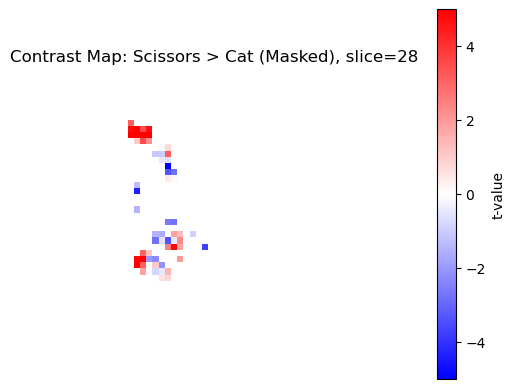

In [20]:
# 3) Plot a slice
slice_idx = 28
plt.imshow(t_map_masked[:, :, slice_idx], cmap="bwr", vmin=-5, vmax=5)
plt.colorbar(label="t-value")
plt.title("Contrast Map: Scissors > Cat (Masked), slice={}".format(slice_idx))
plt.axis("off")
plt.show()

## Second Part: ROI Analysis

In [23]:
# Load ROI masks
vt_mask_path = "subj1/mask4_vt.nii.gz"
face_mask_path = "subj1/mask8_face_vt.nii.gz"
house_mask_path = "subj1/mask8_house_vt.nii.gz"

vt_mask = nib.load(vt_mask_path).get_fdata() > 0  # Ventral Temporal ROI
face_mask = nib.load(face_mask_path).get_fdata() > 0  # Face ROI
house_mask = nib.load(house_mask_path).get_fdata() > 0  # House ROI

# Generate random ROIs
brain_mask = vt_mask | face_mask | house_mask  # Approximation of the whole brain

# Random inside ROI: Within the brain
random_roi_inside = np.random.choice([False, True], size=vt_mask.shape, p=[0.995, 0.005]) & brain_mask

# Random outside ROI: Outside the brain
random_roi_outside = np.random.choice([False, True], size=vt_mask.shape, p=[0.999, 0.001]) & ~brain_mask

# Store masks in a dictionary for convenience
roi_masks = {
    "Ventral Temporal": vt_mask,
    "Face": face_mask,
    "House": house_mask,
    "Random Inside": random_roi_inside,
    "Random Outside": random_roi_outside,
}

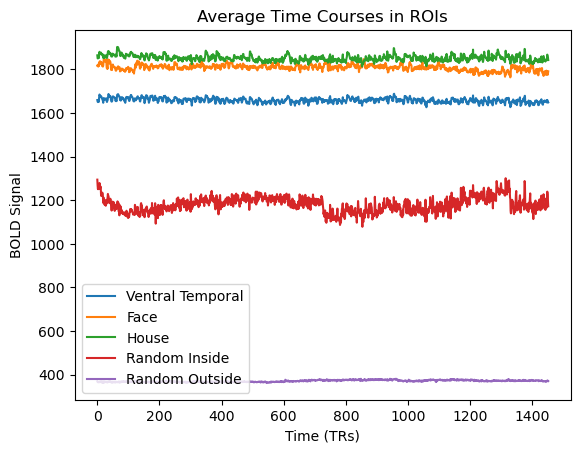

In [24]:
# Extract average time courses for each ROI
time_courses = {}
for roi_name, mask in roi_masks.items():
    roi_bold_data = bold_data[mask]  # Extract voxel data for the ROI
    avg_time_course = np.mean(roi_bold_data, axis=0)  # Average across voxels
    time_courses[roi_name] = avg_time_course

    # Plot the time course
    plt.plot(avg_time_course, label=roi_name)

# Customize the plotS
plt.title("Average Time Courses in ROIs")
plt.xlabel("Time (TRs)")
plt.ylabel("BOLD Signal")
plt.legend()
plt.show()

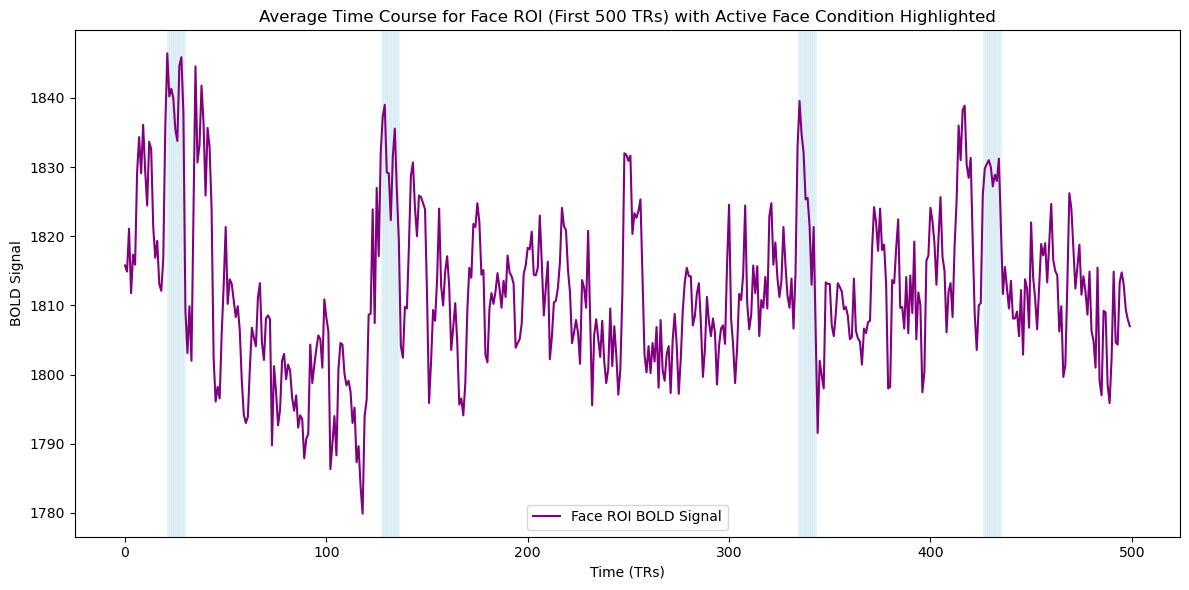

In [25]:
# Extract average time course for the Face ROI

face_bold_data = bold_data[roi_masks["Face"]]  # Extract voxel data for the Face ROI
avg_face_time_course = np.mean(face_bold_data, axis=0)  # Average across voxels

# Find active periods for the face condition in the design matrix
face_active = design_matrix["face"] == 1  # Boolean array indicating active periods

# Zoom into the first 500 time points
time_points = 500
avg_face_time_course = avg_face_time_course[:time_points]
face_active = face_active[:time_points]

# Plot the average time course
plt.figure(figsize=(12, 6))
plt.plot(avg_face_time_course, label="Face ROI BOLD Signal", color="purple", linewidth=1.5)

# Highlight active periods for the face condition
for i, active in enumerate(face_active):
    if active:
        plt.axvspan(i, i + 1, color="lightblue", alpha=0.2)  # Highlight with azure blue shading

# Customize the plot
plt.title("Average Time Course for Face ROI (First 500 TRs) with Active Face Condition Highlighted")
plt.xlabel("Time (TRs)")
plt.ylabel("BOLD Signal")
plt.legend()
plt.tight_layout()
plt.show()

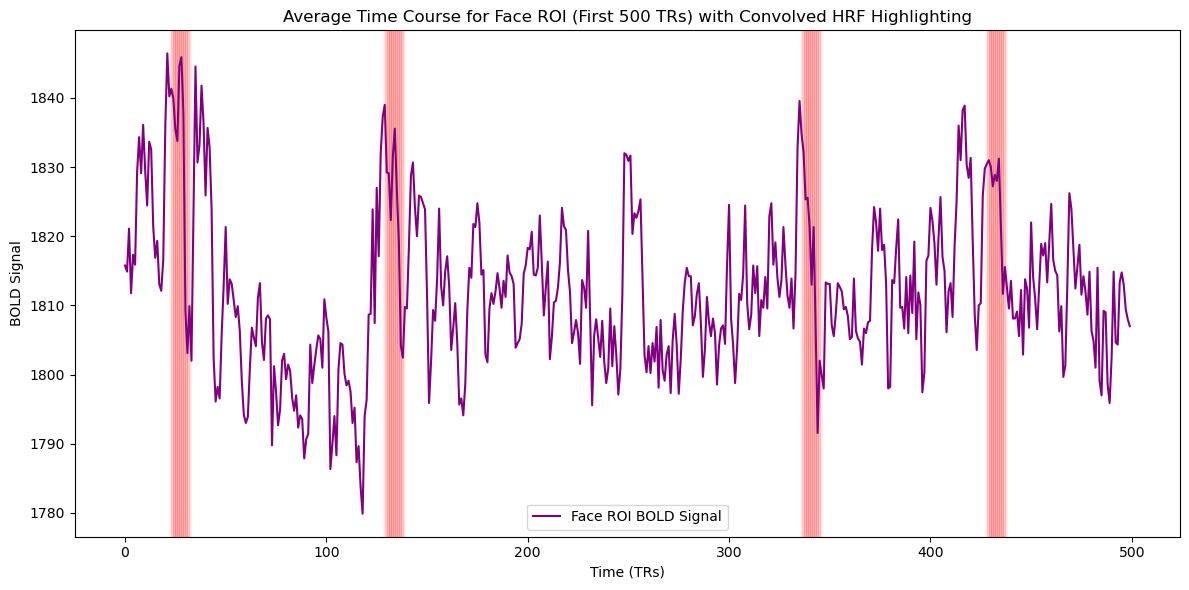

In [26]:
# Extract average time course for the Face ROI
face_bold_data = bold_data[roi_masks["Face"]]  # Extract voxel data for the Face ROI
avg_face_time_course = np.mean(face_bold_data, axis=0)  # Average across voxels

# Use the convolved design matrix to extract face activity
convolved_face_activity = convolved_matrix["face"].values  # Convolved HRF for face condition

# Zoom into the first 500 time points
time_points = 500
avg_face_time_course = avg_face_time_course[:time_points]
convolved_face_activity = convolved_face_activity[:time_points]

# Plot the average time course
plt.figure(figsize=(12, 6))
plt.plot(avg_face_time_course, label="Face ROI BOLD Signal", color="purple", linewidth=1.5)

# Highlight active periods using the convolved matrix
for i in range(len(convolved_face_activity)):
    alpha_value = convolved_face_activity[i] / convolved_face_activity.max()  # Normalize for transparency
    if alpha_value > 0:  # Only highlight periods with activity
        plt.axvspan(i, i + 1, color="red", alpha=alpha_value * 0.2)  # Scaled transparency for HRF

# Customize the plot
plt.title("Average Time Course for Face ROI (First 500 TRs) with Convolved HRF Highlighting")
plt.xlabel("Time (TRs)")
plt.ylabel("BOLD Signal")
plt.legend()
plt.tight_layout()
plt.show()


In [27]:
# Extract Beta Values for Each ROI
roi_beta_values = {}

# Iterate through each ROI
for roi_name, mask in roi_masks.items():
    # Extract beta values for voxels in the ROI
    roi_betas = beta_maps[mask]  # Shape: (N_voxels, N_conditions)
    roi_beta_values[roi_name] = roi_betas


In [28]:
# Calculate % Signal Change
roi_percent_signal_change = {}

# Extract constant terms for 12 runs
constant_term_indices = list(range(-12, 0))  # Last 12 columns are the constant terms

for roi_name, betas in roi_beta_values.items():
    # Extract the beta values for the conditions (excluding the last 12 columns)
    condition_betas = betas[:, :-12]  # Shape: (N_voxels, N_conditions)

    # Extract the constant terms for each run
    constant_terms = betas[:, constant_term_indices]  # Shape: (N_voxels, 12)

    # Calculate the mean constant term across runs for each voxel
    mean_constant_term = np.mean(constant_terms, axis=1)  # Shape: (N_voxels,)

    # Compute percent signal change
    percent_change = (condition_betas / mean_constant_term[:, np.newaxis]) * 100
    roi_percent_signal_change[roi_name] = percent_change


In [29]:
# Average Across Voxels Within Each ROI
roi_mean_percent_change = {}

for roi_name, percent_changes in roi_percent_signal_change.items():
    # Compute the mean across all voxels in the ROI
    mean_percent_change = np.mean(percent_changes, axis=0)  # Shape: (N_conditions,)
    roi_mean_percent_change[roi_name] = mean_percent_change

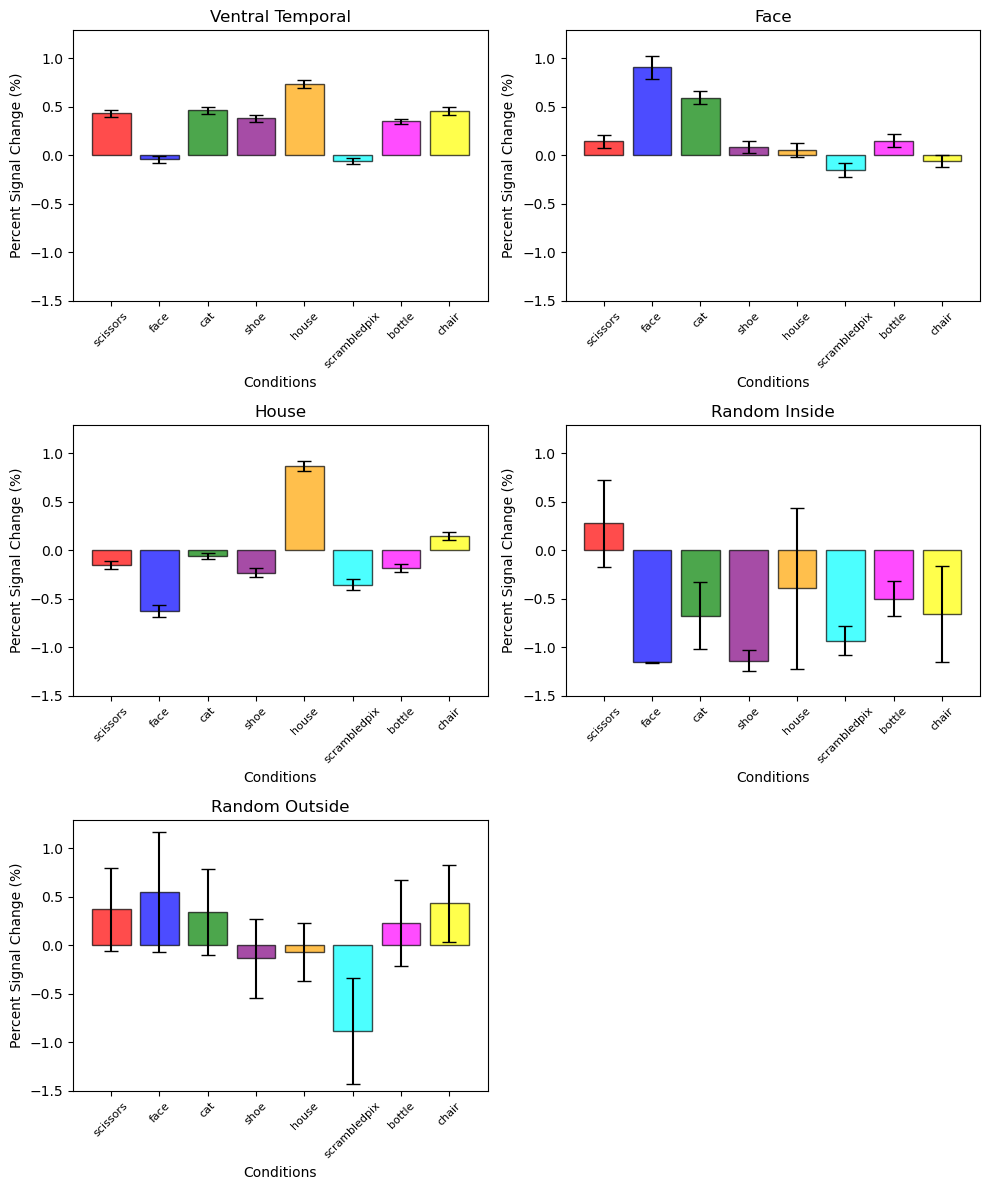

In [30]:
# Plot Average Beta Estimates

# Example unique condition names and corresponding colors
unique_conditions = ["scissors", "face", "cat", "shoe", "house", "scrambledpix", "bottle", "chair"]
colors = ["red", "blue", "green", "purple", "orange", "cyan", "magenta", "yellow"]

# Example SEM values for each condition
roi_sem = {
    roi_name: np.std(roi_percent_signal_change[roi_name], axis=0) / np.sqrt(len(roi_percent_signal_change[roi_name]))
    for roi_name in roi_percent_signal_change
}

# Determine the number of ROIs and calculate grid size
n_rois = len(roi_mean_percent_change)
n_cols = 2  # Number of columns in the grid
n_rows = int(np.ceil(n_rois / n_cols))  # Number of rows needed

# Find the global y-axis limits across all ROIs
all_mean_values = np.concatenate([values for values in roi_mean_percent_change.values()])
all_sem_values = np.concatenate([roi_sem[roi_name] for roi_name in roi_mean_percent_change.keys()])

y_min = -1.5 
y_max = (all_mean_values + all_sem_values).max() * 1.1  # Add 10% margin

# Create the subplots grid dynamically
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 4))
axes = axes.flatten()  # Flatten the grid for easier iteration

# Plot each ROI in a subplot
for idx, (roi_name, mean_values) in enumerate(roi_mean_percent_change.items()):
    ax = axes[idx]  # Select the current subplot
    sem_values = roi_sem[roi_name]  # SEM for error bars

    # Plot bar graph with error bars
    ax.bar(
        range(len(mean_values)),          # X positions
        mean_values,                      # Heights (mean percent signal change)
        yerr=sem_values,                  # Error bars (SEM)
        color=colors[:len(mean_values)],  # Color for each bar
        alpha=0.7,                        # Transparency
        capsize=5,                        # Size of error bar caps
        edgecolor="black"                 # Outline for bars
    )

    # Add subplot labels and title
    ax.set_title(f"{roi_name}", fontsize=12)
    ax.set_xlabel("Conditions", fontsize=10)
    ax.set_ylabel("Percent Signal Change (%)", fontsize=10)

    # Set custom tick labels for the conditions
    ax.set_xticks(np.arange(len(unique_conditions)))
    ax.set_xticklabels(unique_conditions, rotation=45, fontsize=8)

    # Set consistent y-axis limits
    ax.set_ylim(y_min, y_max)

# Hide any unused subplots
for idx in range(len(roi_mean_percent_change), len(axes)):
    axes[idx].axis("off")  # Turn off unused subplots

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

# Third Part: Generalize across multiple subjects

In [31]:
def load_subject_data(bold_path, labels_path):
    """
    Load fMRI BOLD data and labels for a subject.

    Parameters:
        bold_path (str): Path to the subject's BOLD data (NIfTI file).
        labels_path (str): Path to the subject's labels file (CSV).

    Returns:
        bold_data (numpy.ndarray): 4D BOLD data array.
        labels (pandas.DataFrame): Labels DataFrame with 'Condition' and 'Run'.
    """
    # Load the fMRI BOLD data
    bold_img = nib.load(bold_path)
    bold_data = bold_img.get_fdata()

    # Load the labels
    labels = pd.read_csv(labels_path, sep=" ", header=0, names=["Condition", "Run"])

    return bold_data, labels

In [32]:
def calculate_roi_percent_signal_change(beta_maps, roi_masks):
    """
    Calculate percent signal change for each ROI.

    Parameters:
        beta_maps (numpy.ndarray): Beta coefficient maps.
        roi_masks (dict): Dictionary of ROI masks.

    Returns:
        roi_percent_signal_change (dict): Percent signal change for each ROI.
        roi_mean_percent_change (dict): Mean percent signal change across voxels in each ROI.
        roi_sem (dict): SEM for percent signal change in each ROI.
    """
    roi_percent_signal_change = {}
    roi_mean_percent_change = {}
    roi_sem = {}

    constant_term_indices = list(range(-12, 0))  # Last 12 columns are the constant terms

    for roi_name, mask in roi_masks.items():
        roi_betas = beta_maps[mask]  # Extract beta values for this ROI
        #print(f"Shape of beta maps for ROI '{roi_name}': {roi_betas.shape}")  # Debugging

        # Skip ROIs with no voxels
        if roi_betas.shape[0] == 0:
            print(f"Skipping ROI '{roi_name}' due to no voxels.")
            continue

        # Exclude constant terms for conditions
        condition_betas = roi_betas[:, :-12]
        constant_terms = roi_betas[:, constant_term_indices]
        mean_constant_term = np.mean(constant_terms, axis=1)

        # Calculate percent signal change
        percent_change = (condition_betas / mean_constant_term[:, np.newaxis]) * 100
        roi_percent_signal_change[roi_name] = percent_change  # Shape: (n_voxels, n_conditions)

        # Aggregate across voxels
        roi_mean_percent_change[roi_name] = np.mean(percent_change, axis=0)  # Mean: (n_conditions,)
        roi_sem[roi_name] = (
            np.std(percent_change, axis=0) / np.sqrt(percent_change.shape[0])  # SEM: (n_conditions,)
            if percent_change.shape[0] > 1
            else np.zeros(percent_change.shape[1])  # Handle single-voxel ROIs
        )

        # Debugging: Print shapes
        #print(f"Shape of percent change for ROI '{roi_name}': {percent_change.shape}")
        #print(f"Mean percent signal change for ROI '{roi_name}': {roi_mean_percent_change[roi_name].shape}")
        #print(f"SEM for ROI '{roi_name}': {roi_sem[roi_name].shape}")

    return roi_percent_signal_change, roi_mean_percent_change, roi_sem

In [33]:
def plot_roi_mean_percent_change(roi_mean_percent_change, roi_sem, unique_conditions, colors):
    """
    Plot bar graphs for mean percent signal changes.

    Parameters:
        roi_mean_percent_change (dict): Mean percent signal change for each ROI.
        roi_sem (dict): SEM for each ROI.
        unique_conditions (list): List of condition names.
        colors (list): List of colors for the bars.
    """
    n_rois = len(roi_mean_percent_change)
    n_cols = 2
    n_rows = int(np.ceil(n_rois / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 4))
    axes = axes.flatten()

    # Concatenate all values to calculate global y-axis limits
    all_mean_values = np.concatenate([values for values in roi_mean_percent_change.values()])
    all_sem_values = np.concatenate([values for values in roi_sem.values()])
    y_min = -1.5
    y_max = (all_mean_values + all_sem_values).max() * 1.1

    for idx, (roi_name, mean_values) in enumerate(roi_mean_percent_change.items()):
        ax = axes[idx]
        sem_values = roi_sem[roi_name]

        # Plot bar graph
        ax.bar(
            range(len(mean_values)),
            mean_values,
            yerr=sem_values,
            color=colors[:len(mean_values)],
            alpha=0.7,
            capsize=5,
            edgecolor="black"
        )
        ax.set_title(f"{roi_name}", fontsize=12)
        ax.set_xlabel("Conditions", fontsize=10)
        ax.set_ylabel("Percent Signal Change (%)", fontsize=10)
        ax.set_xticks(np.arange(len(unique_conditions)))
        ax.set_xticklabels(unique_conditions, rotation=45, fontsize=8)
        ax.set_ylim(y_min, y_max)

    for idx in range(len(roi_mean_percent_change), len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()


In [34]:
def analyze_subject(subject_id, bold_path, labels_path, hrf_path, unique_conditions, colors):
    """
    Perform subject-level analysis: GLM fitting, ROI signal extraction, and visualization.

    Parameters:
        subject_id (str): Subject ID.
        bold_path (str): Path to the subject's BOLD data (NIfTI file).
        labels_path (str): Path to the subject's labels file (CSV).
        hrf_path (str): Path to the HRF data (MAT file).
        unique_conditions (list): List of condition names.
        colors (list): List of colors for visualization.

    Returns:
        roi_mean_percent_change (dict): Mean percent signal change for each ROI.
    """
    # Step 1: Load Subject Data
    print(f"Loading subject {subject_id} data...")
    bold_data, labels = load_subject_data(bold_path, labels_path)

    # Step 2: Load ROI Masks
    print(f"Loading ROI masks for subject {subject_id}...")
    roi_masks = load_subject_roi_masks(subject_id)

    # Step 3: Create Design Matrix
    print("Creating design matrix...")
    design_matrix = create_design_matrix(labels)

    # Step 4: Modify Convolved Matrix
    print("Modifying design matrix...")
    design_matrix_with_intercepts = add_run_intercepts(design_matrix, labels)

    # Step 5: Load HRF and Create Convolved Matrix
    print("Loading HRF and convolving design matrix...")
    hrf_data = loadmat(hrf_path)
    hrf_sampled = hrf_data.get("hrf_sampled", None).flatten()  # Use the downsampled HRF
    convolved_matrix = convolve_conditions(design_matrix_with_intercepts, hrf_sampled)
    assert bold_data.shape[-1] == convolved_matrix.shape[0], "Mismatch between BOLD volumes and design matrix rows."

    # Step 6: Fit GLM
    print("Fitting GLM...")
    residuals, beta_maps = fit_glm_and_generate_beta_maps(bold_data, convolved_matrix.values)

    # Step 7: ROI Analysis
    print("Extracting ROI signal changes...")
    roi_percent_signal_change, roi_mean_percent_change, roi_sem = calculate_roi_percent_signal_change(beta_maps, roi_masks)

    # Step 8: Visualization
    print("Visualizing ROI results...")
    plot_roi_mean_percent_change(roi_mean_percent_change, roi_sem, unique_conditions, colors)

    print(f"Subject {subject_id} analysis complete.")
    return roi_mean_percent_change

In [35]:
def load_subject_data(bold_path, labels_path):
    """
    Load fMRI BOLD data and labels for a subject.

    Parameters:
        bold_path (str): Path to the subject's BOLD data (NIfTI file).
        labels_path (str): Path to the subject's labels file (CSV).

    Returns:
        bold_data (numpy.ndarray): 4D BOLD data array.
        labels (pandas.DataFrame): Labels DataFrame with 'Condition' and 'Run'.
    """
    # Load the fMRI BOLD data
    bold_img = nib.load(bold_path)
    bold_data = bold_img.get_fdata()

    # Load the labels
    labels = pd.read_csv(labels_path, sep=" ", header=0, names=["Condition", "Run"])

    return bold_data, labels

In [36]:
def calculate_roi_percent_signal_change(beta_maps, roi_masks):
    """
    Calculate percent signal change for each ROI.

    Parameters:
        beta_maps (numpy.ndarray): Beta coefficient maps.
        roi_masks (dict): Dictionary of ROI masks.

    Returns:
        roi_percent_signal_change (dict): Percent signal change for each ROI.
        roi_mean_percent_change (dict): Mean percent signal change across voxels in each ROI.
        roi_sem (dict): SEM for percent signal change in each ROI.
    """
    roi_percent_signal_change = {}
    roi_mean_percent_change = {}
    roi_sem = {}

    constant_term_indices = list(range(-12, 0))  # Last 12 columns are the constant terms

    for roi_name, mask in roi_masks.items():
        roi_betas = beta_maps[mask]  # Extract beta values for this ROI
        #print(f"Shape of beta maps for ROI '{roi_name}': {roi_betas.shape}")  # Debugging

        # Skip ROIs with no voxels
        if roi_betas.shape[0] == 0:
            print(f"Skipping ROI '{roi_name}' due to no voxels.")
            continue

        # Exclude constant terms for conditions
        condition_betas = roi_betas[:, :-12]
        constant_terms = roi_betas[:, constant_term_indices]
        mean_constant_term = np.mean(constant_terms, axis=1)

        # Calculate percent signal change
        percent_change = (condition_betas / mean_constant_term[:, np.newaxis]) * 100
        roi_percent_signal_change[roi_name] = percent_change  # Shape: (n_voxels, n_conditions)

        # Aggregate across voxels
        roi_mean_percent_change[roi_name] = np.mean(percent_change, axis=0)  # Mean: (n_conditions,)
        roi_sem[roi_name] = (
            np.std(percent_change, axis=0) / np.sqrt(percent_change.shape[0])  # SEM: (n_conditions,)
            if percent_change.shape[0] > 1
            else np.zeros(percent_change.shape[1])  # Handle single-voxel ROIs
        )

        # Debugging: Print shapes
        #print(f"Shape of percent change for ROI '{roi_name}': {percent_change.shape}")
        #print(f"Mean percent signal change for ROI '{roi_name}': {roi_mean_percent_change[roi_name].shape}")
        #print(f"SEM for ROI '{roi_name}': {roi_sem[roi_name].shape}")

    return roi_percent_signal_change, roi_mean_percent_change, roi_sem

In [37]:
def plot_roi_mean_percent_change(roi_mean_percent_change, roi_sem, unique_conditions, colors):
    """
    Plot bar graphs for mean percent signal changes.

    Parameters:
        roi_mean_percent_change (dict): Mean percent signal change for each ROI.
        roi_sem (dict): SEM for each ROI.
        unique_conditions (list): List of condition names.
        colors (list): List of colors for the bars.
    """
    n_rois = len(roi_mean_percent_change)
    n_cols = 2
    n_rows = int(np.ceil(n_rois / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, n_rows * 4))
    axes = axes.flatten()

    # Concatenate all values to calculate global y-axis limits
    all_mean_values = np.concatenate([values for values in roi_mean_percent_change.values()])
    all_sem_values = np.concatenate([values for values in roi_sem.values()])
    y_min = -1.5
    y_max = (all_mean_values + all_sem_values).max() * 1.1

    for idx, (roi_name, mean_values) in enumerate(roi_mean_percent_change.items()):
        ax = axes[idx]
        sem_values = roi_sem[roi_name]

        # Plot bar graph
        ax.bar(
            range(len(mean_values)),
            mean_values,
            yerr=sem_values,
            color=colors[:len(mean_values)],
            alpha=0.7,
            capsize=5,
            edgecolor="black"
        )
        ax.set_title(f"{roi_name}", fontsize=12)
        ax.set_xlabel("Conditions", fontsize=10)
        ax.set_ylabel("Percent Signal Change (%)", fontsize=10)
        ax.set_xticks(np.arange(len(unique_conditions)))
        ax.set_xticklabels(unique_conditions, rotation=45, fontsize=8)
        ax.set_ylim(y_min, y_max)

    for idx in range(len(roi_mean_percent_change), len(axes)):
        axes[idx].axis("off")

    plt.tight_layout()
    plt.show()


In [41]:
def analyze_subject(subject_id, bold_path, labels_path, hrf_path, unique_conditions, colors):
    """
    Perform subject-level analysis: GLM fitting, ROI signal extraction, and visualization.

    Parameters:
        subject_id (str): Subject ID.
        bold_path (str): Path to the subject's BOLD data (NIfTI file).
        labels_path (str): Path to the subject's labels file (CSV).
        hrf_path (str): Path to the HRF data (MAT file).
        unique_conditions (list): List of condition names.
        colors (list): List of colors for visualization.

    Returns:
        roi_mean_percent_change (dict): Mean percent signal change for each ROI.
    """
    # Step 1: Load Subject Data
    print(f"Loading subject {subject_id} data...")
    bold_data, labels = load_subject_data(bold_path, labels_path)

    # Step 2: Load ROI Masks
    print(f"Loading ROI masks for subject {subject_id}...")
    roi_masks = load_subject_roi_masks(subject_id)

    # Step 3: Create Design Matrix
    print("Creating design matrix...")
    design_matrix = create_design_matrix(labels)

    # Step 4: Modify Convolved Matrix
    print("Modifying design matrix...")
    design_matrix_with_intercepts = add_run_intercepts(design_matrix, labels)

    # Step 5: Load HRF and Create Convolved Matrix
    print("Loading HRF and convolving design matrix...")
    hrf_data = loadmat(hrf_path)
    hrf_sampled = hrf_data.get("hrf_sampled", None).flatten()  # Use the downsampled HRF
    convolved_matrix = convolve_conditions(design_matrix_with_intercepts, hrf_sampled)
    assert bold_data.shape[-1] == convolved_matrix.shape[0], "Mismatch between BOLD volumes and design matrix rows."

    # Step 6: Fit GLM
    print("Fitting GLM...")
    residuals, beta_maps = fit_glm_and_generate_beta_maps(bold_data, convolved_matrix.values)

    # Step 7: ROI Analysis
    print("Extracting ROI signal changes...")
    roi_percent_signal_change, roi_mean_percent_change, roi_sem = calculate_roi_percent_signal_change(beta_maps, roi_masks)

    # Step 8: Visualization
    #print("Visualizing ROI results...")
    #plot_roi_mean_percent_change(roi_mean_percent_change, roi_sem, unique_conditions, colors)

    print(f"Subject {subject_id} analysis complete.")
    return roi_mean_percent_change


In [39]:
def load_subject_roi_masks(subject_id):
    """
    Load ROI masks for a specific subject using global base paths.

    Parameters:
        subject_id (str): Subject ID.

    Returns:
        dict: Dictionary of ROI masks for the subject.
    """
    # Generate full paths for this subject
    vt_mask_path = base_vt_mask_path.format(subject_id)
    face_mask_path = base_face_mask_path.format(subject_id)
    house_mask_path = base_house_mask_path.format(subject_id)

    # Load the masks
    vt_mask = nib.load(vt_mask_path).get_fdata() > 0
    face_mask = nib.load(face_mask_path).get_fdata() > 0
    house_mask = nib.load(house_mask_path).get_fdata() > 0

    # Generate additional masks if needed
    brain_mask = vt_mask | face_mask | house_mask
    random_roi_inside = np.random.choice([False, True], size=vt_mask.shape, p=[0.995, 0.005]) & brain_mask
    random_roi_outside = np.random.choice([False, True], size=vt_mask.shape, p=[0.999, 0.001]) & ~brain_mask

    return {
        "Ventral Temporal": vt_mask,
        "Face": face_mask,
        "House": house_mask,
        "Random Inside": random_roi_inside,
        "Random Outside": random_roi_outside,
    }

## Singular Subject

Loading subject 1 data...
Loading ROI masks for subject 1...
Creating design matrix...
Modifying design matrix...
Loading HRF and convolving design matrix...
Fitting GLM...
Extracting ROI signal changes...
Visualizing ROI results...


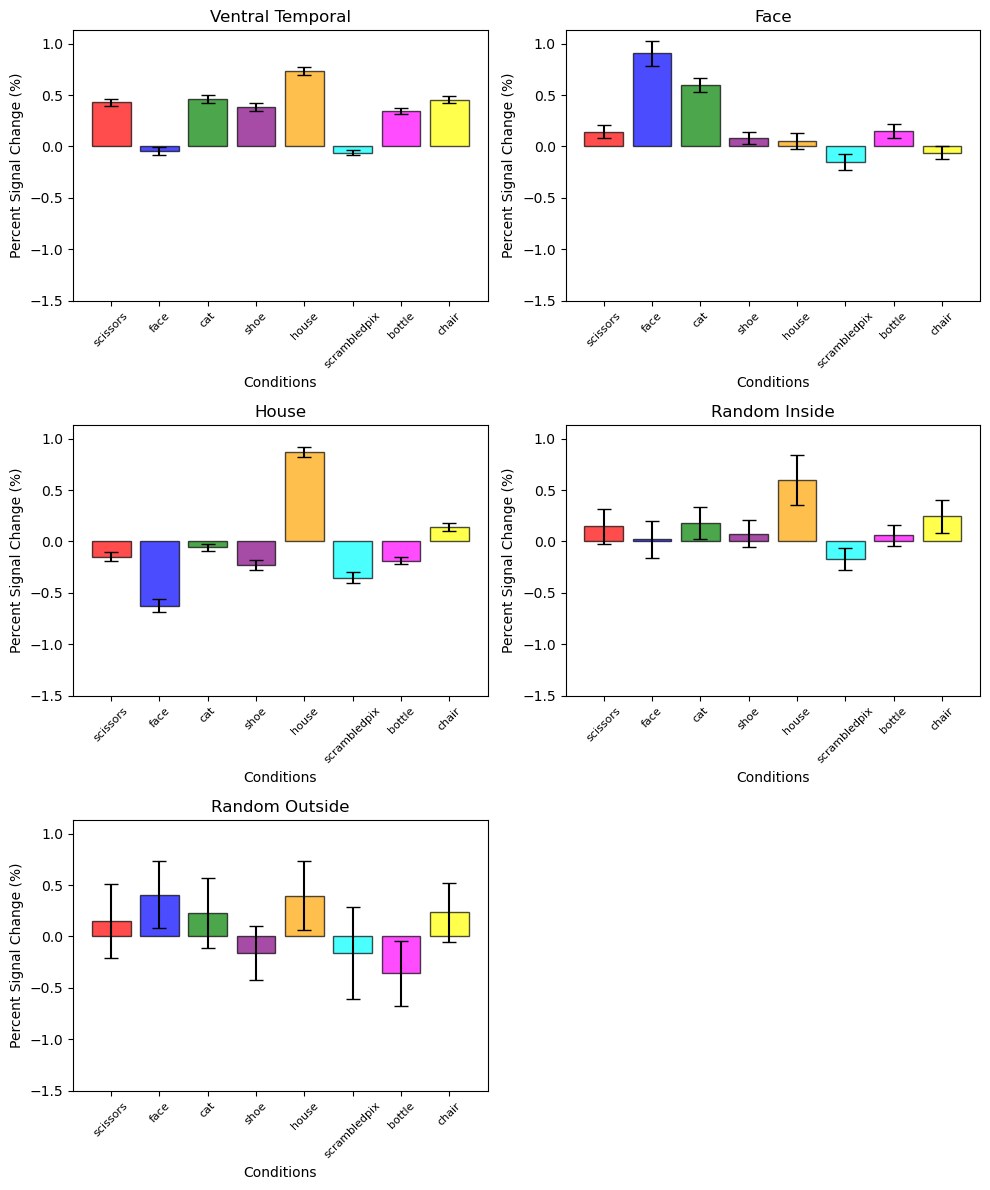

Subject 1 analysis complete.


In [40]:
# Paths to subject-specific data
bold_path = "subj1/bold.nii.gz"
labels_path = "subj1/labels.txt"
hrf_path = "hrf.mat"

base_vt_mask_path = "subj{}/mask4_vt.nii.gz"
base_face_mask_path = "subj{}/mask8_face_vt.nii.gz"
base_house_mask_path = "subj{}/mask8_house_vt.nii.gz"

# Run the analysis for a single subject
roi_mean_percent_change = analyze_subject(
    1,  # Subject ID
    bold_path,
    labels_path,
    hrf_path,
    unique_conditions,
    colors
)

## Multiple Subject

In [42]:
def analyze_multiple_subjects(subject_ids, base_bold_path, base_labels_path, hrf_path, unique_conditions, colors):
    """
    Perform analysis across multiple subjects and average results across them.

    Parameters:
        subject_ids (list): List of subject IDs (e.g., ["1", "2", "3", "4"]).
        base_bold_path (str): Base path for BOLD files (e.g., "subj{}/bold.nii.gz").
        base_labels_path (str): Base path for labels files (e.g., "subj{}/labels.txt").
        hrf_path (str): Path to the HRF file (shared across subjects).
        roi_masks (dict): Dictionary of ROI masks (same across subjects).
        unique_conditions (list): List of condition names.
        colors (list): List of colors for visualization.

    Returns:
        group_mean_percent_change (dict): Mean percent signal change across subjects for each ROI.
        group_sem (dict): Standard error of the mean (SEM) across subjects for each ROI.
    """
    # Store subject-level results
    all_subjects_percent_change = {roi_name: [] for roi_name in roi_masks.keys()}

    # Iterate over all subjects
    for subject_id in subject_ids:
        print(f"Analyzing subject {subject_id}...")
        
        # Generate subject-specific paths
        bold_path = base_bold_path.format(subject_id)
        labels_path = base_labels_path.format(subject_id)

        # Perform single-subject analysis
        roi_mean_percent_change = analyze_subject(
            subject_id, bold_path, labels_path, hrf_path, unique_conditions, colors
        )

        # Collect results for group analysis
        for roi_name, mean_percent_change in roi_mean_percent_change.items():
            all_subjects_percent_change[roi_name].append(mean_percent_change)

    # Calculate group-level averages
    group_mean_percent_change = {}
    group_sem = {}

    for roi_name, subject_values in all_subjects_percent_change.items():
        subject_values = np.array(subject_values)  # Convert to numpy array for easier manipulation
        group_mean_percent_change[roi_name] = np.mean(subject_values, axis=0)  # Mean across subjects
        group_sem[roi_name] = np.std(subject_values, axis=0) / np.sqrt(len(subject_values))  # SEM

    # Visualize group results
    print("Visualizing group results...")
    plot_roi_mean_percent_change(group_mean_percent_change, group_sem, unique_conditions, colors)

    print("Group analysis complete.")
    return group_mean_percent_change, group_sem


Analyzing subject 1...
Loading subject 1 data...
Loading ROI masks for subject 1...
Creating design matrix...
Modifying design matrix...
Loading HRF and convolving design matrix...
Fitting GLM...
Extracting ROI signal changes...
Subject 1 analysis complete.
Analyzing subject 2...
Loading subject 2 data...
Loading ROI masks for subject 2...
Creating design matrix...
Modifying design matrix...
Loading HRF and convolving design matrix...
Fitting GLM...
Extracting ROI signal changes...
Skipping ROI 'Random Inside' due to no voxels.
Subject 2 analysis complete.
Analyzing subject 3...
Loading subject 3 data...
Loading ROI masks for subject 3...
Creating design matrix...
Modifying design matrix...
Loading HRF and convolving design matrix...
Fitting GLM...
Extracting ROI signal changes...
Subject 3 analysis complete.
Analyzing subject 4...
Loading subject 4 data...
Loading ROI masks for subject 4...
Creating design matrix...
Modifying design matrix...
Loading HRF and convolving design matrix..

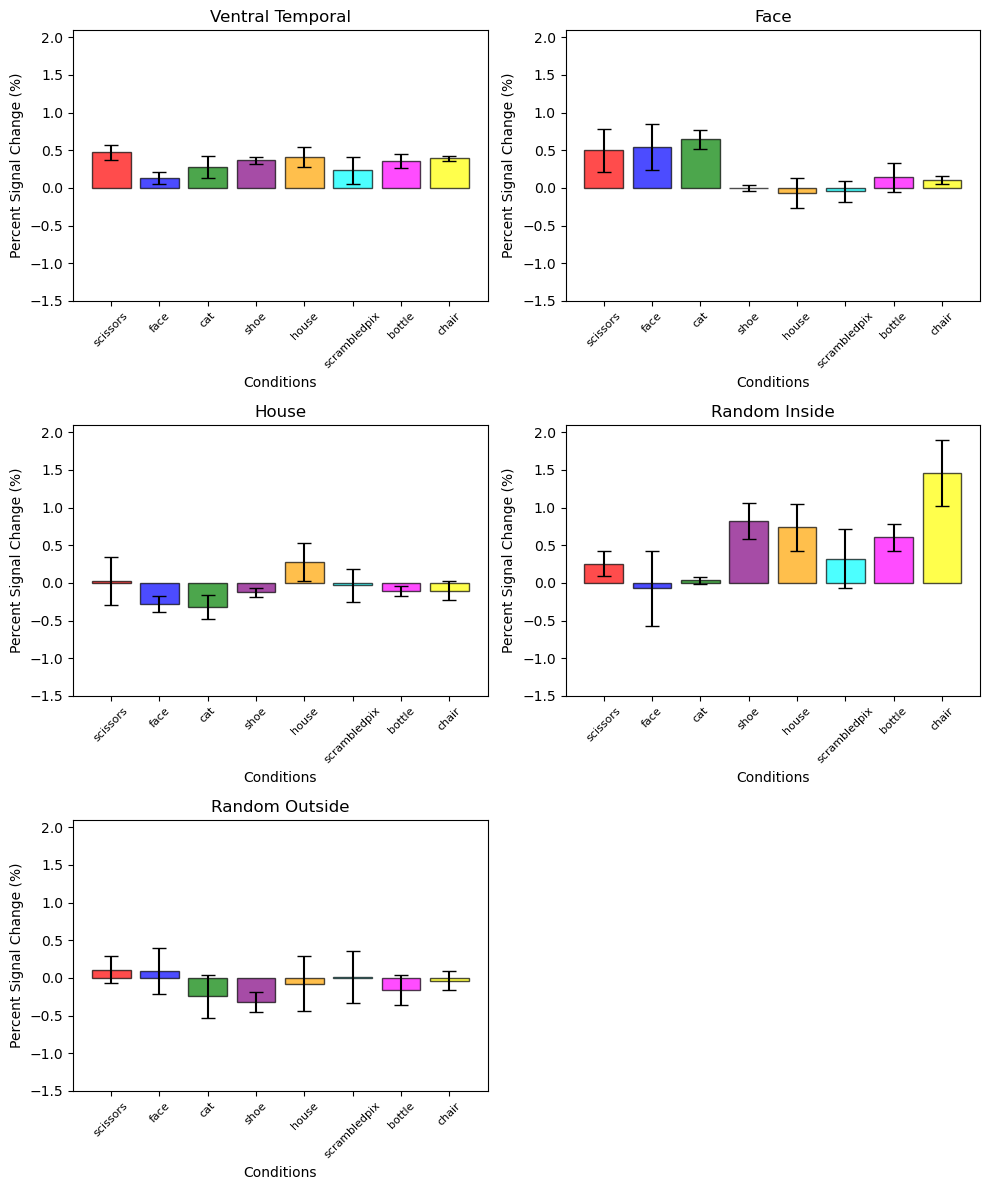

Group analysis complete.


In [43]:
# List of subject IDs
subject_ids = ["1", "2", "3", "4"]

# Base path for BOLD files (subject-specific)
base_bold_path = "subj{}/bold.nii.gz"

# Paths for labels and HRF (shared across subjects)
base_labels_path = "subj{}/labels.txt"
hrf_path = "hrf.mat"

# Run the analysis across multiple subjects
group_mean_percent_change, group_sem = analyze_multiple_subjects(
    subject_ids,
    base_bold_path,
    base_labels_path,
    hrf_path,
    unique_conditions,
    colors
)